In [1]:
!pip install tqdm

In [2]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm


In [3]:
run_training = False
retrain = False
find_learning_rate = False

In [4]:
files = listdir("/home/matasietephi/Descargas/breast_histopathology_images/")
print(len(files))

281


In [5]:
files[0:10]


['12872',
 '9077',
 '14079',
 '15471',
 '12934',
 '8917',
 '12626',
 '10274',
 '12894',
 '14321']

In [6]:
files = listdir("/home/matasietephi/Descargas/breast_histopathology_images/IDC_regular_ps50_idx5/")
len(files)

279

In [7]:
base_path = "/home/matasietephi/Descargas/breast_histopathology_images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

In [8]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [9]:
total_images


277524

In [10]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,12872,/home/matasietephi/Descargas/breast_histopatho...,0
1,12872,/home/matasietephi/Descargas/breast_histopatho...,0
2,12872,/home/matasietephi/Descargas/breast_histopatho...,0
3,12872,/home/matasietephi/Descargas/breast_histopatho...,0
4,12872,/home/matasietephi/Descargas/breast_histopatho...,0


In [14]:

data.shape

(277524, 3)

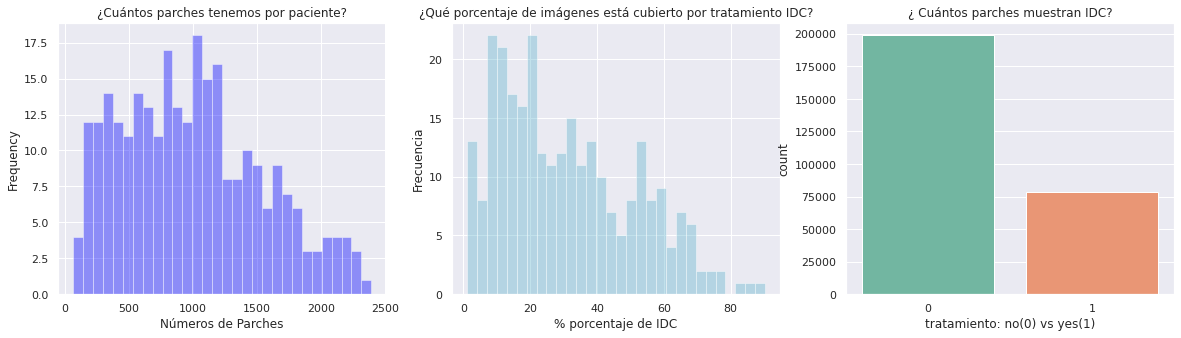

In [35]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Blue", kde=False, bins=30)
ax[0].set_xlabel("Números de Parches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("¿Cuántos parches tenemos por paciente?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="C9", kde=False, bins=30)
ax[1].set_title("¿Qué porcentaje de imágenes está cubierto por tratamiento IDC?")
ax[1].set_ylabel("Frecuencia")
ax[1].set_xlabel("% porcentaje de IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("tratamiento: no(0) vs yes(1)")
ax[2].set_title("¿ Cuántos parches muestran IDC?");

In [16]:
data.target = data.target.astype(np.int)


In [17]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)


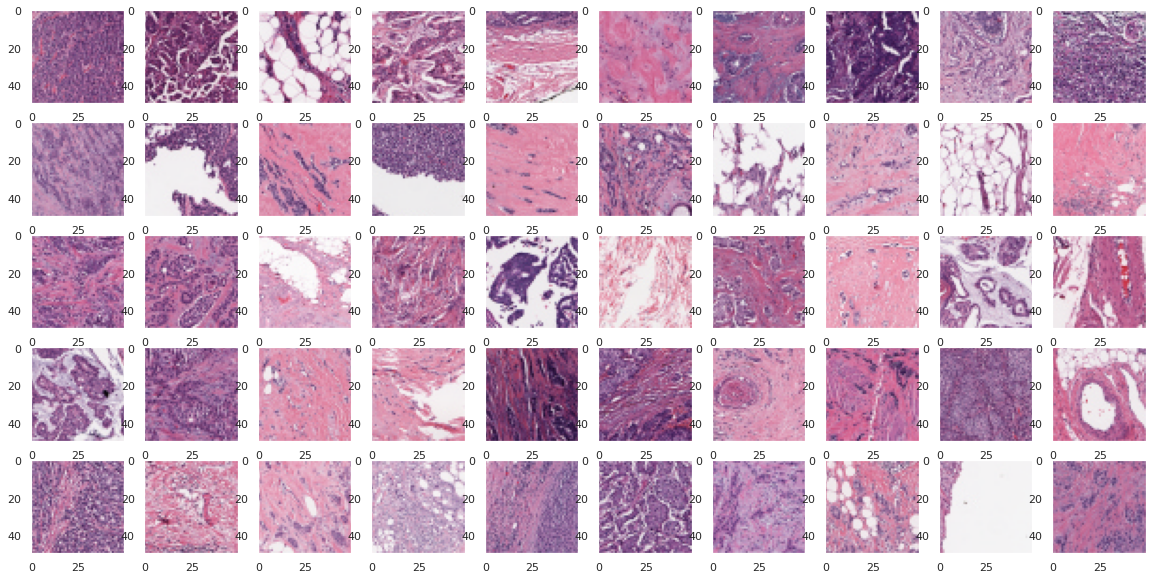

In [19]:
# Muestra la cueadrícula de muestras a procesar por la red neuronal 
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

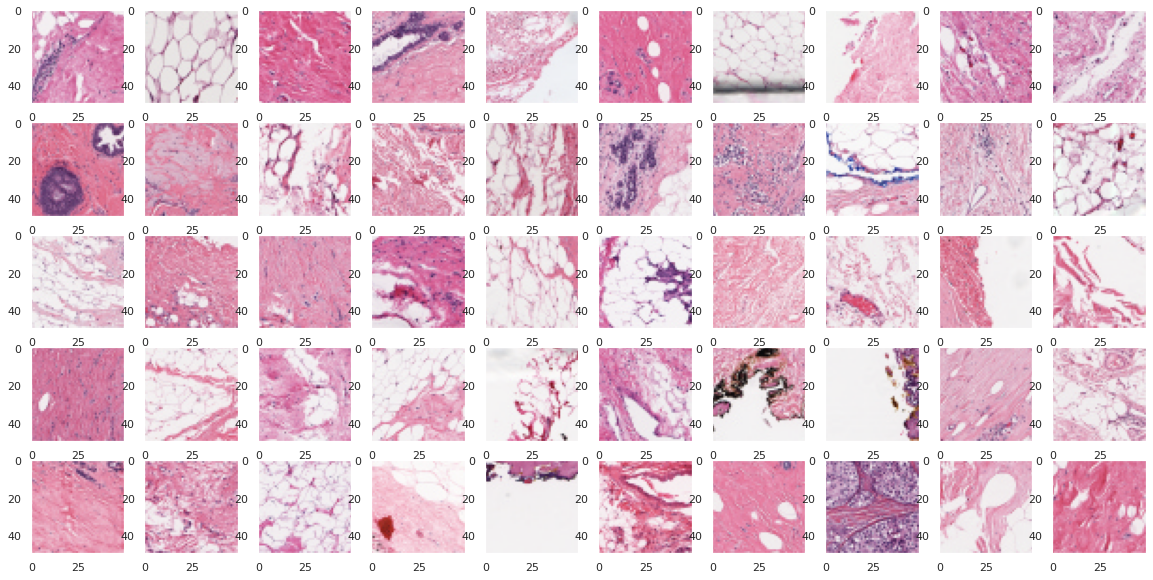

In [20]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [21]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [22]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

,x,y,target,path
0,1251,901,0,/home/matasietephi/Descargas/breast_histopatho...
1,2251,1651,0,/home/matasietephi/Descargas/breast_histopatho...
2,101,1101,0,/home/matasietephi/Descargas/breast_histopatho...
3,2401,751,0,/home/matasietephi/Descargas/breast_histopatho...
4,1251,101,0,/home/matasietephi/Descargas/breast_histopatho...


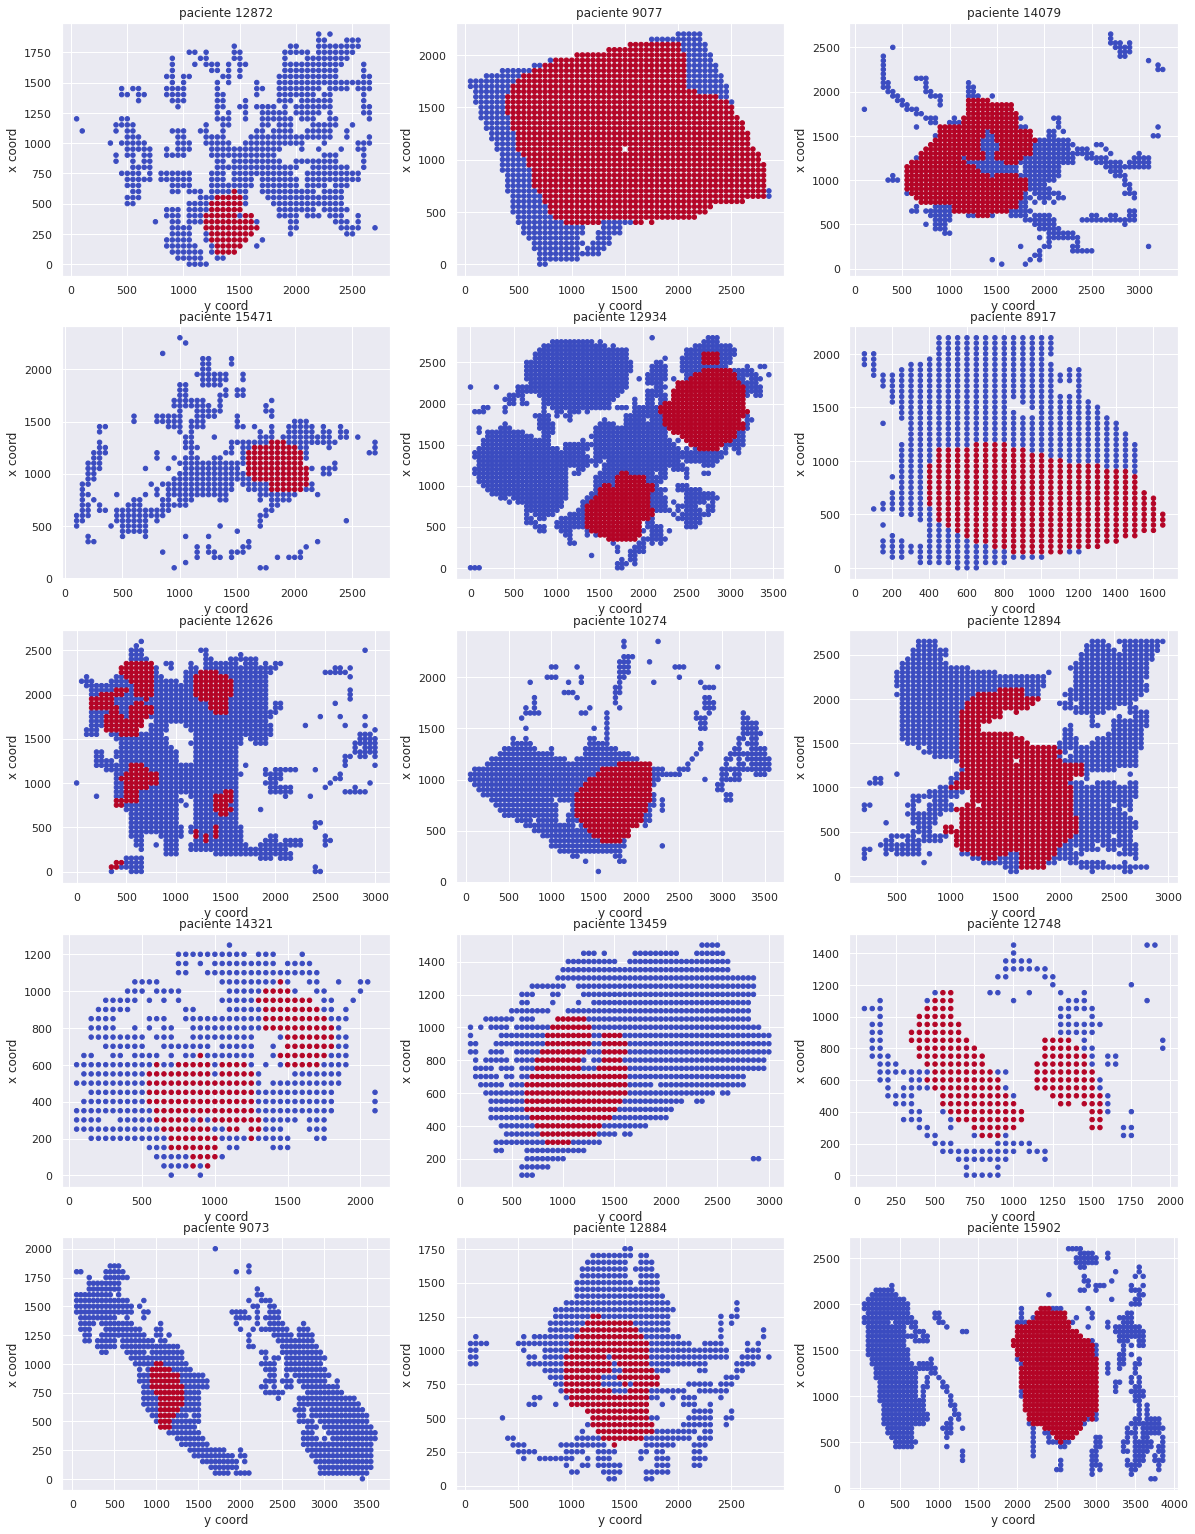

In [30]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("paciente " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

In [24]:

def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

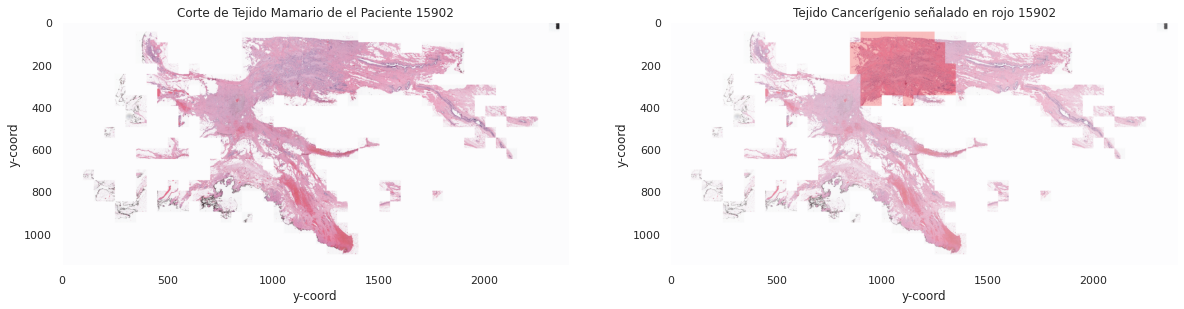

In [26]:
example = "13617" # Selección del individuo a estudiar
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Corte de Tejido Mamario de el Paciente " + patient_id)
ax[1].set_title("Tejido Cancerígenio señalado en rojo " + patient_id);

In [27]:
broken_patches

['/home/matasietephi/Descargas/breast_histopathology_images/IDC_regular_ps50_idx5/13617/0/13617_idx5_x2351_y1051_class0.png',
 '/home/matasietephi/Descargas/breast_histopathology_images/IDC_regular_ps50_idx5/13617/0/13617_idx5_x2301_y1101_class0.png',
 '/home/matasietephi/Descargas/breast_histopathology_images/IDC_regular_ps50_idx5/13617/0/13617_idx5_x2351_y1101_class0.png',
 '/home/matasietephi/Descargas/breast_histopathology_images/IDC_regular_ps50_idx5/13617/0/13617_idx5_x2351_y1_class0.png']